# Comparing TIAToolbox Nucleus Segmentation with IDC Pan-Cancer Annotations

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/07_comparing_with_idc_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

IDC hosts the **Pan-Cancer-Nuclei-Seg-DICOM** analysis results, which contain nucleus annotations for slides across multiple TCGA cancer collections. These annotations are stored as DICOM Microscopy Bulk Simple Annotations (ANN) objects.

In this notebook, we:
1. Find a TCGA slide that has Pan-Cancer nucleus annotations in IDC
2. Download both the slide and its annotations
3. Parse the DICOM ANN annotations using `highdicom`
4. Run TIAToolbox's HoVer-Net on the same region
5. Compare the two sets of results visually and quantitatively

**GPU recommended** for HoVer-Net inference.

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [ ]:
%%capture
%pip install "tiatoolbox==1.6.0" idc-index openslide-bin "numcodecs<0.16" highdicom wsidicom shapely

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import os
import joblib
import pydicom
import highdicom as hd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon as ShapelyPolygon
from PIL import Image

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    try:
        torch.zeros(1, device="cuda")
    except RuntimeError:
        print("CUDA available but not functional — falling back to CPU")
        device = "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Note: GPU is recommended. In Colab: Runtime > Change runtime type > T4 GPU")

  check_for_updates()



Using device: cuda


## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [ ]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 20:13:17 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  highdicom: 0.27.0
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 10.8 GB available
GPU:  Tesla T4, 15360 MiB, 580.82.07


## 1. Find a Slide with Pan-Cancer Annotations

The `Pan-Cancer-Nuclei-Seg-DICOM` analysis result contains nucleus centroid annotations for TCGA slides. We use `ann_index` to find annotation series and link them back to the original slide.

In [ ]:
idc_client = IDCClient()
idc_client.fetch_index("sm_index")
idc_client.fetch_index("ann_index")
idc_client.fetch_index("ann_group_index")

In [ ]:
# Find Pan-Cancer annotation series with their source slides
pan_cancer_anns = idc_client.sql_query("""
    SELECT
        ann.SeriesInstanceUID as ann_series_uid,
        ann.referenced_SeriesInstanceUID as slide_series_uid,
        i_ann.collection_id as ann_collection,
        i_slide.collection_id as slide_collection,
        i_slide.PatientID,
        ROUND(i_slide.series_size_MB, 1) as slide_size_mb,
        ROUND(i_ann.series_size_MB, 1) as ann_size_mb,
        s.ObjectiveLensPower,
        s.min_PixelSpacing_2sf as pixel_spacing_mm
    FROM ann_index ann
    JOIN index i_ann ON ann.SeriesInstanceUID = i_ann.SeriesInstanceUID
    JOIN index i_slide ON ann.referenced_SeriesInstanceUID = i_slide.SeriesInstanceUID
    JOIN sm_index s ON ann.referenced_SeriesInstanceUID = s.SeriesInstanceUID
    WHERE i_ann.analysis_result_id = 'Pan-Cancer-Nuclei-Seg-DICOM'
        AND i_slide.collection_id = 'tcga_luad'
        AND s.ObjectiveLensPower >= 20
    ORDER BY i_slide.series_size_MB ASC
    LIMIT 5
""")

print(f"Found {len(pan_cancer_anns)} slides with Pan-Cancer annotations")
pan_cancer_anns

Found 5 slides with Pan-Cancer annotations


ann_series_uid  \
0  1.2.826.0.1.3680043.10.511.3.91019719271535320...   
1  1.2.826.0.1.3680043.10.511.3.24281270393224739...   
2  1.2.826.0.1.3680043.10.511.3.82023501754748781...   
3  1.2.826.0.1.3680043.10.511.3.19089142880439068...   
4  1.2.826.0.1.3680043.10.511.3.10896686787869776...   

                                    slide_series_uid ann_collection  \
0  1.3.6.1.4.1.5962.99.1.1069499334.1192011488.16...      tcga_luad   
1  1.3.6.1.4.1.5962.99.1.1049767027.2140062076.16...      tcga_luad   
2  1.3.6.1.4.1.5962.99.1.1050568592.1009686511.16...      tcga_luad   
3  1.3.6.1.4.1.5962.99.1.1076094084.938462296.163...      tcga_luad   
4  1.3.6.1.4.1.5962.99.1.1041397527.203423315.163...      tcga_luad   

  slide_collection     PatientID  slide_size_mb  ann_size_mb  \
0        tcga_luad  TCGA-55-8207           11.4          2.8   
1        tcga_luad  TCGA-44-7661           17.2          0.0   
2        tcga_luad  TCGA-55-8204           32.5         11.6   
3        tcga_luad  TCGA-55-8505           40.9         11.4   
4        tcga_luad  TCGA-99-7458           51.7         23.4   

   ObjectiveLensPower  pixel_spacing_mm  
0                  40           0.00025  
1                  40           0.00025  
2                  40           0.00025  
3                  40           0.00025  
4                  40           0.00025

In [ ]:
# Select the smallest slide
selected = pan_cancer_anns.iloc[0]
slide_series_uid = selected['slide_series_uid']
ann_series_uid = selected['ann_series_uid']

print(f"Selected slide:")
print(f"  Patient: {selected['PatientID']}")
print(f"  Slide: {slide_series_uid} ({selected['slide_size_mb']} MB)")
print(f"  ANN: {ann_series_uid} ({selected['ann_size_mb']} MB)")
print(f"  Objective: {selected['ObjectiveLensPower']}x")

Selected slide:
  Patient: TCGA-55-8207
  Slide: 1.3.6.1.4.1.5962.99.1.1069499334.1192011488.1637452071878.2.0 (11.4 MB)
  ANN: 1.2.826.0.1.3680043.10.511.3.91019719271535320770002647219991927 (2.8 MB)
  Objective: 40x


## 2. Download the Slide and its Annotations

In [ ]:
download_dir = './slides'
ann_dir = './annotations'
os.makedirs(download_dir, exist_ok=True)
os.makedirs(ann_dir, exist_ok=True)

# Download the slide
idc_client.download_from_selection(
    downloadDir=download_dir,
    seriesInstanceUID=[slide_series_uid],
    dirTemplate='%SeriesInstanceUID'
)

# Download the ANN object (flat, no directory template)
idc_client.download_from_selection(
    downloadDir=ann_dir,
    seriesInstanceUID=[ann_series_uid],
    dirTemplate=None
)

slide_path = os.path.join(download_dir, slide_series_uid)
ann_files = [f for f in os.listdir(ann_dir) if f.endswith('.dcm')]
print(f"Downloaded slide: {slide_path} (series {slide_series_uid}")
print(f"Downloaded {len(ann_files)} ANN file(s)")

Downloaded slide: ./slides/1.3.6.1.4.1.5962.99.1.1069499334.1192011488.1637452071878.2.0
Downloaded 1 ANN file(s)


Slide: DICOMWSIReader, dimensions: (16307, 15251)
MPP: [0.252 0.252]


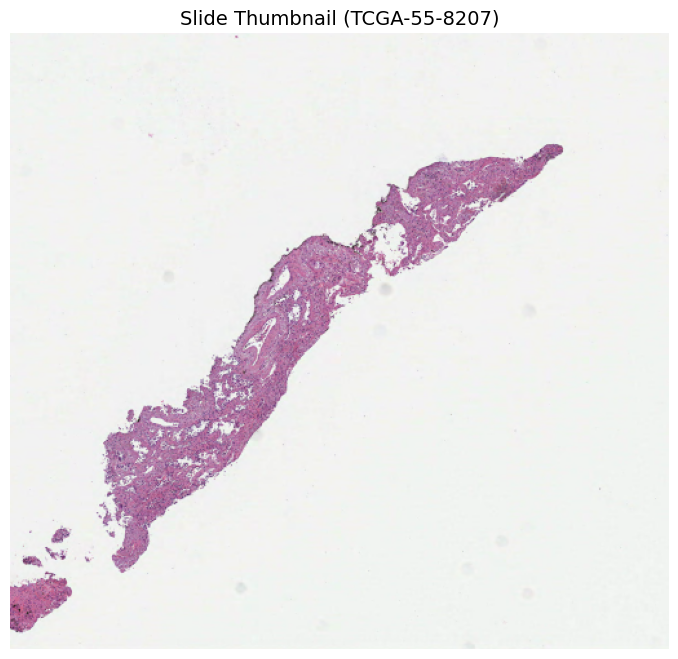

In [ ]:
# Open slide with TIAToolbox
reader = WSIReader.open(slide_path)

# DICOMWSIReader may not populate objective_power or mpp
info = reader.info
if info.objective_power is None:
    info.objective_power = float(selected['ObjectiveLensPower'])
if info.mpp is None:
    pixel_spacing_um = float(selected['pixel_spacing_mm']) * 1000
    info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])

print(f"Slide: {type(reader).__name__}, dimensions: {info.slide_dimensions}")
print(f"MPP: {info.mpp}")

thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
plt.figure(figsize=(10, 8))
plt.imshow(thumbnail)
plt.title(f"Slide Thumbnail ({selected['PatientID']})", fontsize=14)
plt.axis('off')
plt.show()

## 3. Parse IDC DICOM ANN Annotations

The Pan-Cancer-Nuclei-Seg-DICOM annotations are stored as DICOM Microscopy Bulk Simple Annotations (ANN). We use `highdicom` to parse them and extract nucleus centroids.

In [ ]:
# Load the ANN DICOM object
ann_path = os.path.join(ann_dir, ann_files[0])
ann = hd.ann.annread(ann_path)

# Explore annotation groups
ann_groups = ann.get_annotation_groups()
print(f"Number of annotation groups: {len(ann_groups)}")
print(f"Annotation coordinate type: {ann.annotation_coordinate_type}")

for i, group in enumerate(ann_groups):
    print(f"\nGroup {i+1}:")
    print(f"  Label: {group.label}")
    print(f"  Graphic type: {group.graphic_type}")
    print(f"  Number of annotations: {group.number_of_annotations}")

Number of annotation groups: 1
Annotation coordinate type: AnnotationCoordinateTypeValues.SCOORD

Group 1:
  Label: Nuclei
  Graphic type: GraphicTypeValues.POLYGON
  Number of annotations: 10128


In [ ]:
# Extract nucleus centroids from the first group
annotation_group = ann.get_annotation_group(number=1)
nuclei_annotations = annotation_group.get_graphic_data(
    coordinate_type=ann.annotation_coordinate_type
)

print(f"Total IDC annotations: {len(nuclei_annotations)}")
if len(nuclei_annotations) > 0:
    print(f"First annotation shape: {nuclei_annotations[0].shape}")
    print(f"First annotation (coordinates): {nuclei_annotations[0][:3]}...")

Total IDC annotations: 10128
First annotation shape: (13, 2)
First annotation (coordinates): [[ 2389.9 12001.8]
 [ 2389.9 12008.3]
 [ 2391.1 12009.1]]...


### Convert Annotation Coordinates

DICOM ANN coordinates may be in millimeters (SCOORD3D) or pixel coordinates (SCOORD). We need to get the pixel spacing to convert between coordinate systems if needed.

In [ ]:
# Get pixel spacing from sm_instance_index for coordinate conversion
idc_client.fetch_index("sm_instance_index")

pixel_info = idc_client.sql_query(f"""
    SELECT
        TotalPixelMatrixColumns as width,
        TotalPixelMatrixRows as height,
        PixelSpacing_0 as pixel_spacing_mm
    FROM sm_instance_index
    WHERE SeriesInstanceUID = '{slide_series_uid}'
    ORDER BY TotalPixelMatrixColumns DESC
    LIMIT 1
""")

px_spacing = pixel_info.iloc[0]['pixel_spacing_mm']
print(f"Pixel spacing: {px_spacing:.6f} mm")
print(f"Full resolution dimensions: {pixel_info.iloc[0]['width']} x {pixel_info.iloc[0]['height']}")

Pixel spacing: 0.000252 mm
Full resolution dimensions: 16307.0 x 15251.0


In [ ]:
# Convert annotation coordinates to pixel coordinates at baseline resolution
# SCOORD3D coordinates are in mm; convert by dividing by pixel spacing
idc_centroids_mm = []
for ann_data in nuclei_annotations:
    if ann_data.ndim == 1:
        # Point annotation: [x, y, z] or [x, y]
        idc_centroids_mm.append(ann_data[:2])
    else:
        # Polygon: take centroid
        idc_centroids_mm.append(ann_data[:, :2].mean(axis=0))

idc_centroids_mm = np.array(idc_centroids_mm)
print(f"Annotation coordinate range: x=[{idc_centroids_mm[:, 0].min():.2f}, {idc_centroids_mm[:, 0].max():.2f}]")
print(f"                           y=[{idc_centroids_mm[:, 1].min():.2f}, {idc_centroids_mm[:, 1].max():.2f}]")

# Convert to pixel coordinates
if ann.annotation_coordinate_type.value == '3D':
    # SCOORD3D: coordinates in mm
    idc_centroids_px = idc_centroids_mm / px_spacing
else:
    # SCOORD: already in pixels
    idc_centroids_px = idc_centroids_mm

print(f"\nPixel coordinate range: x=[{idc_centroids_px[:, 0].min():.0f}, {idc_centroids_px[:, 0].max():.0f}]")
print(f"                       y=[{idc_centroids_px[:, 1].min():.0f}, {idc_centroids_px[:, 1].max():.0f}]")
print(f"Total IDC nuclei centroids: {len(idc_centroids_px)}")

Annotation coordinate range: x=[3.89, 13949.69]
                           y=[2273.53, 15109.94]

Pixel coordinate range: x=[4, 13950]
                       y=[2274, 15110]
Total IDC nuclei centroids: 10128


## 4. Extract a Region of Interest and Visualize IDC Annotations

Tile shape: (2048, 2048, 3)
Baseline bounding box: (4395, 5994) to (8457, 10056)


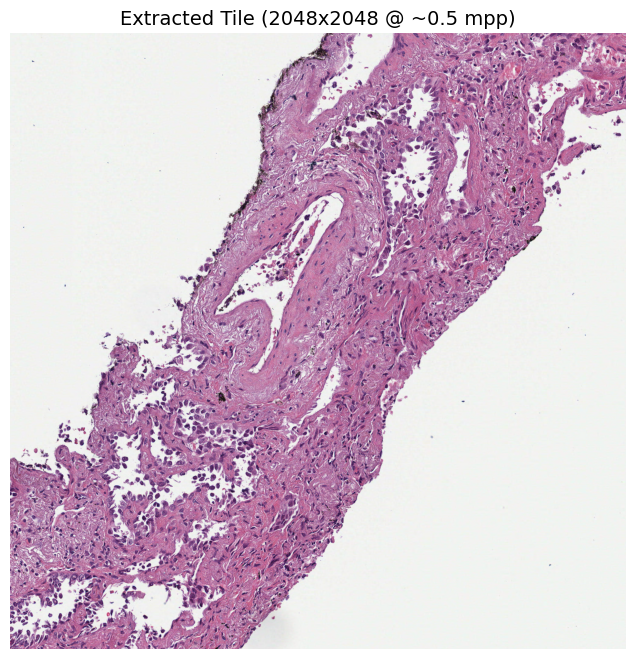

In [ ]:
# Choose a tissue-rich region
gray = np.mean(thumbnail, axis=2)
tissue_mask = gray < 200
tissue_coords = np.argwhere(tissue_mask)
center_y, center_x = tissue_coords.mean(axis=0).astype(int)

slide_w, slide_h = info.slide_dimensions
baseline_x = int(center_x * slide_w / thumbnail.shape[1])
baseline_y = int(center_y * slide_h / thumbnail.shape[0])

# Extract a 2048x2048 tile in baseline coordinates
# DICOMWSIReader has coordinate issues at non-native resolutions,
# so we read at native resolution and resize if needed.
tile_size = 2048
baseline_mpp = float(info.mpp[0])
target_mpp = 0.5

baseline_extent = int(tile_size * target_mpp / baseline_mpp)

bounds = (
    max(0, baseline_x - baseline_extent // 2),
    max(0, baseline_y - baseline_extent // 2),
    min(slide_w, baseline_x + baseline_extent // 2),
    min(slide_h, baseline_y + baseline_extent // 2),
)

tile = reader.read_bounds(
    bounds=bounds,
    resolution=info.objective_power,
    units="power",
)

if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
    tile = np.array(Image.fromarray(tile).resize((tile_size, tile_size), Image.LANCZOS))

# Compute the baseline bounding box for annotation filtering
tile_baseline_x = bounds[0]
tile_baseline_y = bounds[1]
tile_baseline_w = bounds[2] - bounds[0]
tile_baseline_h = bounds[3] - bounds[1]

# Scale factor from baseline to tile pixels
scale = tile_size / baseline_extent

print(f"Tile shape: {tile.shape}")
print(f"Baseline bounding box: ({tile_baseline_x}, {tile_baseline_y}) to ({bounds[2]}, {bounds[3]})")

plt.figure(figsize=(8, 8))
plt.imshow(tile)
plt.title("Extracted Tile (2048x2048 @ ~0.5 mpp)", fontsize=14)
plt.axis('off')
plt.show()

IDC nuclei in this region: 3136


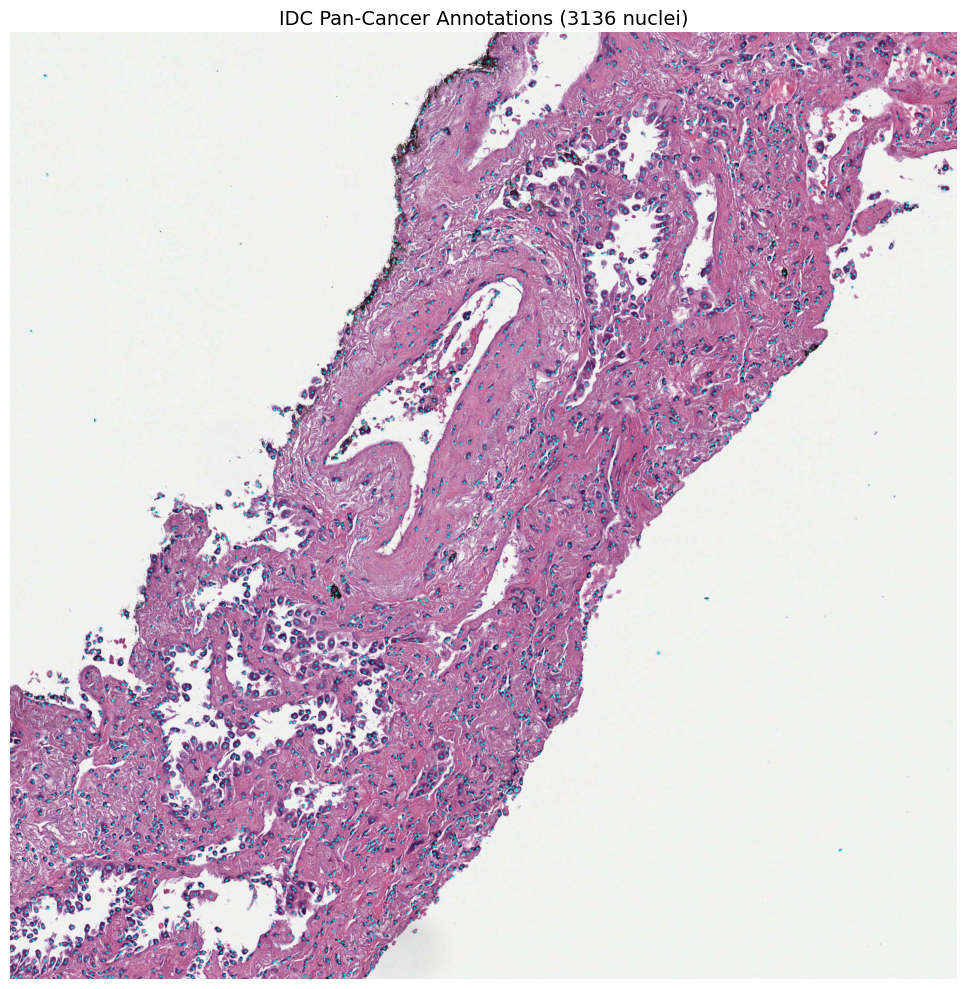

In [ ]:
# Filter IDC centroids to this tile region
in_region = (
    (idc_centroids_px[:, 0] >= tile_baseline_x) &
    (idc_centroids_px[:, 0] < tile_baseline_x + tile_baseline_w) &
    (idc_centroids_px[:, 1] >= tile_baseline_y) &
    (idc_centroids_px[:, 1] < tile_baseline_y + tile_baseline_h)
)

idc_centroids_region = idc_centroids_px[in_region]
print(f"IDC nuclei in this region: {len(idc_centroids_region)}")

# Convert to tile pixel coordinates
idc_tile_coords = (idc_centroids_region - np.array([tile_baseline_x, tile_baseline_y])) * scale

# Visualize IDC annotations on the tile
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tile)
ax.scatter(idc_tile_coords[:, 0], idc_tile_coords[:, 1],
           s=3, c='cyan', alpha=0.5, marker='.')
ax.set_title(f"IDC Pan-Cancer Annotations ({len(idc_centroids_region)} nuclei)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

## 5. Run TIAToolbox HoVer-Net on the Same Region

In [ ]:
# Save tile for HoVer-Net
tile_path = './tile_for_comparison.png'
Image.fromarray(tile).save(tile_path)

# Run HoVer-Net
segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=0,
    num_postproc_workers=0,
    batch_size=8,
)

output = segmentor.predict(
    imgs=[tile_path],
    mode="tile",
    save_dir="./comparison_results/",
    resolution=1.0,
    units="baseline",
    device=device,
)

print("HoVer-Net inference complete!")

  saved_state_dict = torch.load(pretrained_weights, map_location="cpu")

Process Batch: 100%|##############################| 2/2 [00:01<00:00,  1.72it/s]


HoVer-Net inference complete!


In [ ]:
# Load HoVer-Net results
hovernet_nuclei = joblib.load(output[0][1] + '.dat')

# Extract centroids from HoVer-Net
hovernet_centroids = np.array([nuc['centroid'] for nuc in hovernet_nuclei.values()])
hovernet_types = np.array([nuc['type'] for nuc in hovernet_nuclei.values()])

print(f"TIAToolbox HoVer-Net nuclei: {len(hovernet_centroids)}")
print(f"IDC Pan-Cancer nuclei (in region): {len(idc_centroids_region)}")

TIAToolbox HoVer-Net nuclei: 1618
IDC Pan-Cancer nuclei (in region): 3136


## 6. Visual Comparison

Let's compare the two sets of nuclei side-by-side and overlaid.

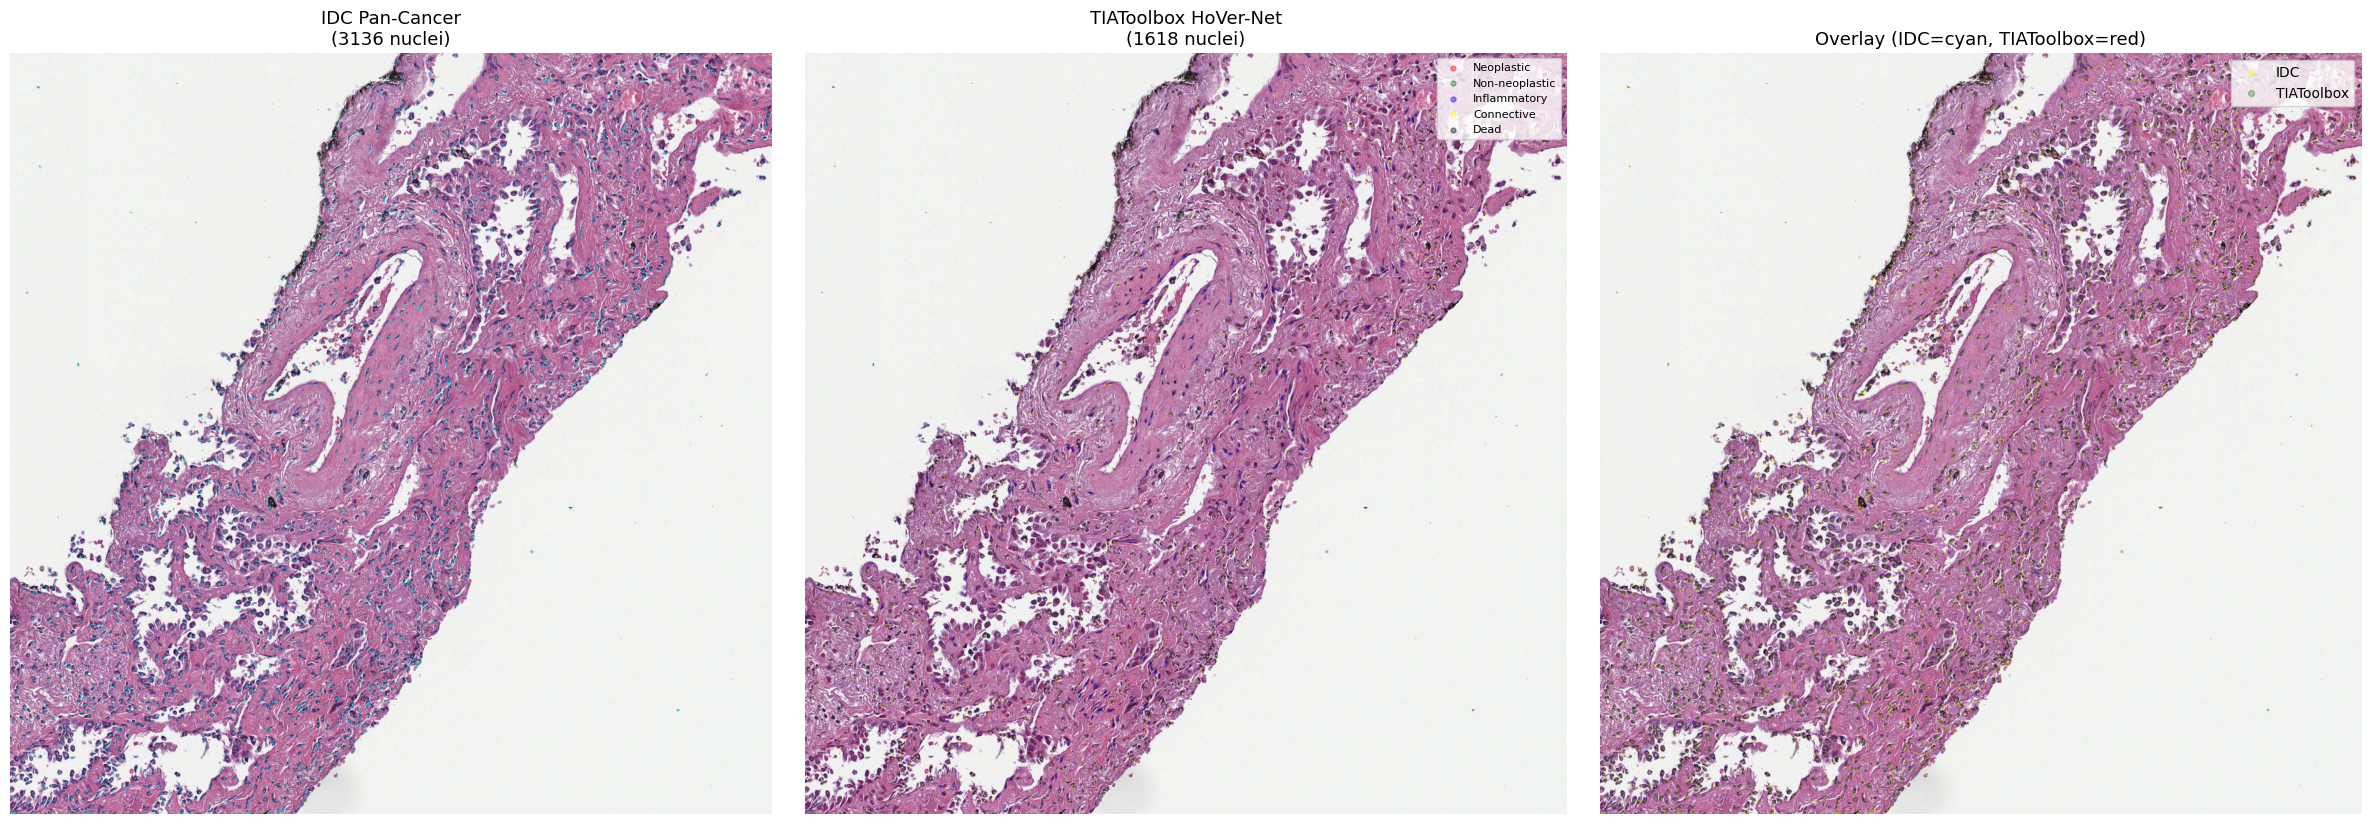

In [ ]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# IDC annotations
axes[0].imshow(tile)
axes[0].scatter(idc_tile_coords[:, 0], idc_tile_coords[:, 1],
                s=2, c='cyan', alpha=0.4, marker='.')
axes[0].set_title(f"IDC Pan-Cancer\n({len(idc_centroids_region)} nuclei)", fontsize=13)
axes[0].axis('off')

# TIAToolbox HoVer-Net
type_colors = {
    1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 5: 'black'
}
type_names = {
    1: 'Neoplastic', 2: 'Non-neoplastic', 3: 'Inflammatory', 4: 'Connective', 5: 'Dead'
}

axes[1].imshow(tile)
for t, color in type_colors.items():
    mask = hovernet_types == t
    if mask.sum() > 0:
        axes[1].scatter(hovernet_centroids[mask, 0], hovernet_centroids[mask, 1],
                        s=2, c=color, alpha=0.4, marker='.', label=type_names[t])
axes[1].set_title(f"TIAToolbox HoVer-Net\n({len(hovernet_centroids)} nuclei)", fontsize=13)
axes[1].legend(fontsize=8, loc='upper right', markerscale=5)
axes[1].axis('off')

# Overlay both
axes[2].imshow(tile)
axes[2].scatter(idc_tile_coords[:, 0], idc_tile_coords[:, 1],
                s=3, c='yellow', alpha=0.3, marker='.', label='IDC')
axes[2].scatter(hovernet_centroids[:, 0], hovernet_centroids[:, 1],
                s=3, c='green', alpha=0.3, marker='.', label='TIAToolbox')
axes[2].set_title("Overlay (IDC=cyan, TIAToolbox=red)", fontsize=13)
axes[2].legend(fontsize=10, loc='upper right', markerscale=5)
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Zoomed-In Comparison

Let's zoom into a smaller region to see individual nuclei.

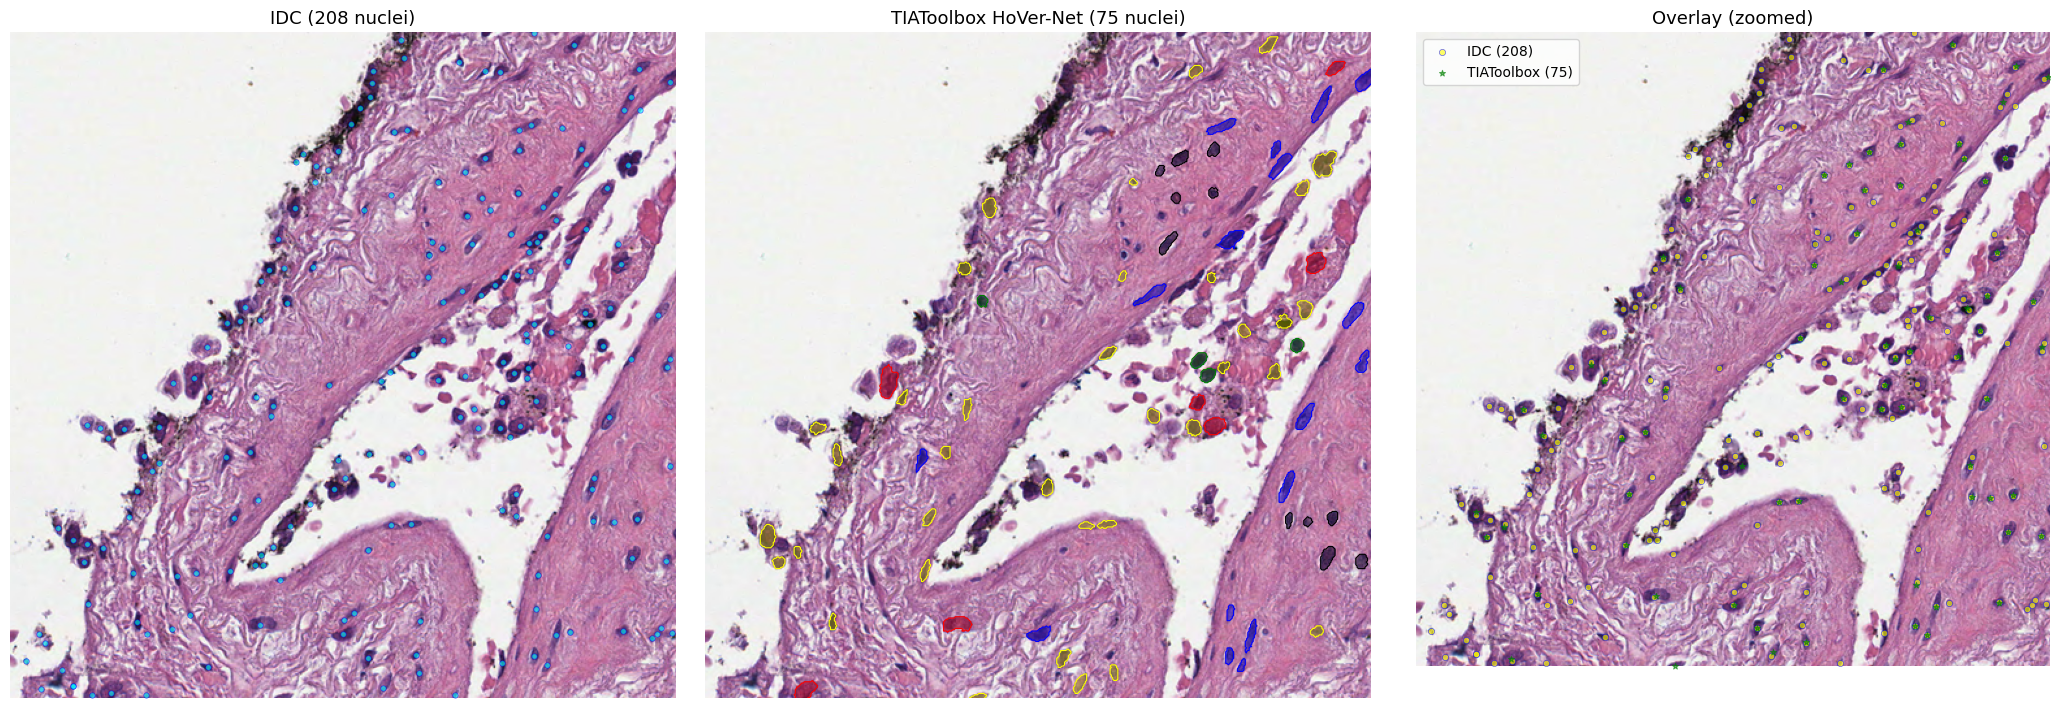

In [ ]:
# Zoom into a 512x512 region
zoom_x, zoom_y = tile_size // 4, tile_size // 4
zoom_size = 512

zoomed = tile[zoom_y:zoom_y+zoom_size, zoom_x:zoom_x+zoom_size]

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Zoomed IDC
axes[0].imshow(zoomed)
idc_in_zoom = idc_tile_coords[
    (idc_tile_coords[:, 0] >= zoom_x) & (idc_tile_coords[:, 0] < zoom_x + zoom_size) &
    (idc_tile_coords[:, 1] >= zoom_y) & (idc_tile_coords[:, 1] < zoom_y + zoom_size)
] - np.array([zoom_x, zoom_y])

axes[0].scatter(idc_in_zoom[:, 0], idc_in_zoom[:, 1],
                s=15, c='cyan', alpha=0.6, marker='o', edgecolors='blue', linewidth=0.5)
axes[0].set_title(f"IDC ({len(idc_in_zoom)} nuclei)", fontsize=13)
axes[0].axis('off')

# Zoomed HoVer-Net with contours
axes[1].imshow(zoomed)
for nuc in hovernet_nuclei.values():
    centroid = nuc['centroid']
    if (zoom_x <= centroid[0] < zoom_x + zoom_size and
        zoom_y <= centroid[1] < zoom_y + zoom_size):
        contour = nuc['contour'] - np.array([zoom_x, zoom_y])
        nuc_type = nuc['type']
        color = type_colors.get(nuc_type, 'gray')
        polygon = MplPolygon(contour, closed=True, fill=True,
                             facecolor=(*plt.cm.colors.to_rgb(color), 0.3),
                             edgecolor=color, linewidth=0.8)
        axes[1].add_patch(polygon)

hovernet_in_zoom = hovernet_centroids[
    (hovernet_centroids[:, 0] >= zoom_x) & (hovernet_centroids[:, 0] < zoom_x + zoom_size) &
    (hovernet_centroids[:, 1] >= zoom_y) & (hovernet_centroids[:, 1] < zoom_y + zoom_size)
]
axes[1].set_title(f"TIAToolbox HoVer-Net ({len(hovernet_in_zoom)} nuclei)", fontsize=13)
axes[1].axis('off')

# Overlay
axes[2].imshow(zoomed)
axes[2].scatter(idc_in_zoom[:, 0], idc_in_zoom[:, 1],
                s=20, c='yellow', alpha=0.6, marker='o', edgecolors='blue',
                linewidth=0.5, label=f'IDC ({len(idc_in_zoom)})', zorder=3)
hovernet_zoom_shifted = hovernet_in_zoom - np.array([zoom_x, zoom_y])
axes[2].scatter(hovernet_zoom_shifted[:, 0], hovernet_zoom_shifted[:, 1],
                s=20, c='green', alpha=0.6, marker='*',
                linewidth=0.8, label=f'TIAToolbox ({len(hovernet_in_zoom)})', zorder=3)
axes[2].set_title("Overlay (zoomed)", fontsize=13)
axes[2].legend(fontsize=10)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 7. Quantitative Comparison

In [ ]:
# Compare nucleus counts
print("Nucleus Count Comparison:")
print("=" * 40)
print(f"IDC Pan-Cancer annotations: {len(idc_centroids_region):6d}")
print(f"TIAToolbox HoVer-Net:       {len(hovernet_centroids):6d}")
ratio = len(hovernet_centroids) / max(len(idc_centroids_region), 1)
print(f"Ratio (TIAToolbox/IDC):     {ratio:.2f}")

Nucleus Count Comparison:
IDC Pan-Cancer annotations:   3136
TIAToolbox HoVer-Net:         1618
Ratio (TIAToolbox/IDC):     0.52


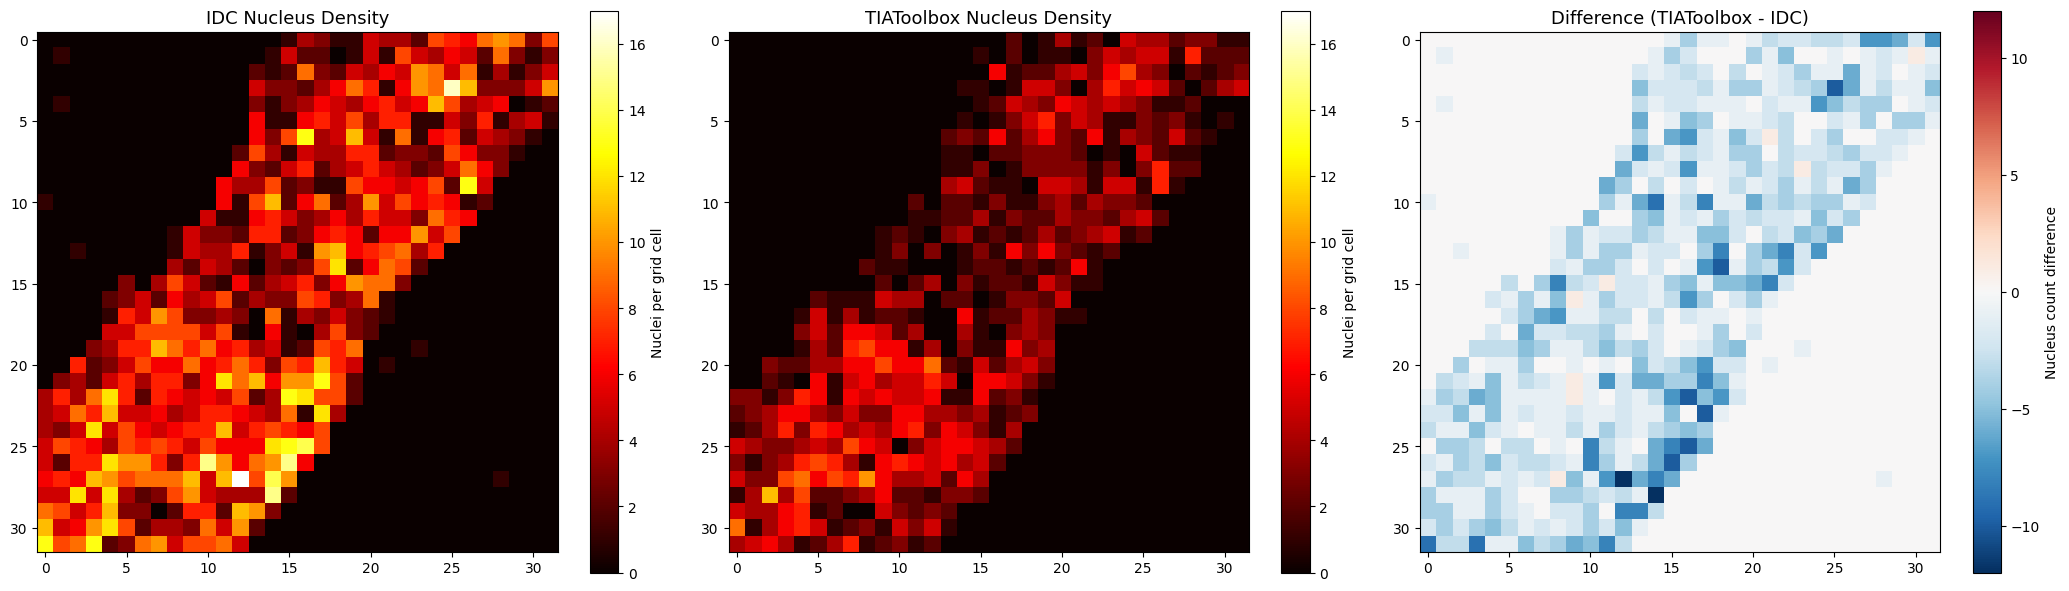

In [ ]:
# Compute spatial density heatmaps for both
grid_size = 64  # Size of each grid cell in tile pixels
n_grid_x = tile_size // grid_size
n_grid_y = tile_size // grid_size

# IDC density
idc_density = np.zeros((n_grid_y, n_grid_x))
for cx, cy in idc_tile_coords:
    gx = min(int(cx / grid_size), n_grid_x - 1)
    gy = min(int(cy / grid_size), n_grid_y - 1)
    if 0 <= gx < n_grid_x and 0 <= gy < n_grid_y:
        idc_density[gy, gx] += 1

# TIAToolbox density
hovernet_density = np.zeros((n_grid_y, n_grid_x))
for cx, cy in hovernet_centroids:
    gx = min(int(cx / grid_size), n_grid_x - 1)
    gy = min(int(cy / grid_size), n_grid_y - 1)
    if 0 <= gx < n_grid_x and 0 <= gy < n_grid_y:
        hovernet_density[gy, gx] += 1

# Plot density heatmaps
vmax = max(idc_density.max(), hovernet_density.max())

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

im0 = axes[0].imshow(idc_density, cmap='hot', vmin=0, vmax=vmax)
axes[0].set_title("IDC Nucleus Density", fontsize=13)
plt.colorbar(im0, ax=axes[0], label="Nuclei per grid cell")

im1 = axes[1].imshow(hovernet_density, cmap='hot', vmin=0, vmax=vmax)
axes[1].set_title("TIAToolbox Nucleus Density", fontsize=13)
plt.colorbar(im1, ax=axes[1], label="Nuclei per grid cell")

# Difference map
diff = hovernet_density - idc_density
vabs = max(abs(diff.min()), abs(diff.max()))
im2 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-vabs, vmax=vabs)
axes[2].set_title("Difference (TIAToolbox - IDC)", fontsize=13)
plt.colorbar(im2, ax=axes[2], label="Nucleus count difference")

plt.tight_layout()
plt.show()

Spatial density correlation: r=0.693, p=1.26e-80


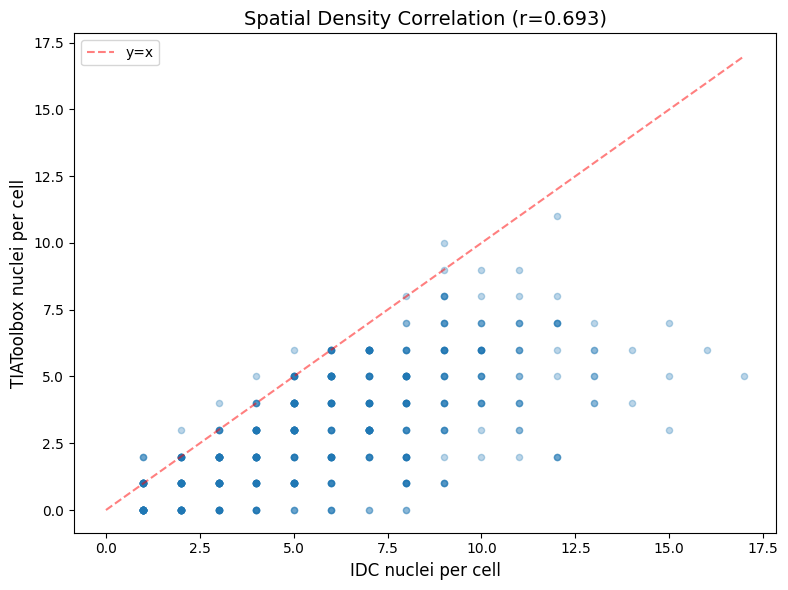

In [ ]:
# Correlation between density maps
from scipy import stats

# Flatten and compute correlation
mask = (idc_density > 0) | (hovernet_density > 0)  # Non-empty cells
if mask.sum() > 2:
    corr, pval = stats.pearsonr(idc_density[mask], hovernet_density[mask])
    print(f"Spatial density correlation: r={corr:.3f}, p={pval:.2e}")

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(idc_density[mask], hovernet_density[mask], alpha=0.3, s=20)
    max_val = max(idc_density.max(), hovernet_density.max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
    ax.set_xlabel("IDC nuclei per cell", fontsize=12)
    ax.set_ylabel("TIAToolbox nuclei per cell", fontsize=12)
    ax.set_title(f"Spatial Density Correlation (r={corr:.3f})", fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.show()

## Summary

In this notebook, we learned how to:

- Use `ann_index` to find IDC's **Pan-Cancer-Nuclei-Seg-DICOM** annotations linked to TCGA slides
- Download both the slide and its DICOM ANN annotation objects
- Parse DICOM ANN objects using `highdicom` to extract nucleus centroids
- Convert between DICOM coordinate systems (mm) and pixel coordinates
- Run TIAToolbox's **HoVer-Net** on the same region for comparison
- **Visually compare** the two sets of results at full and zoomed views
- **Quantitatively compare** using nucleus counts, spatial density heatmaps, and correlation

**Key observations:**
- Both methods detect nuclei in similar regions (high spatial correlation)
- Count differences arise from different detection thresholds and algorithms
- TIAToolbox additionally provides nucleus **type classification** (neoplastic, inflammatory, etc.), while the Pan-Cancer annotations provide centroids
- The two approaches are complementary: IDC provides large-scale pre-computed annotations, while TIAToolbox enables custom analysis with richer per-nucleus information

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5
- **HoVer-Net:** Graham, S., et al. "Hover-Net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images." *Medical Image Analysis* 58 (2019). https://doi.org/10.1016/j.media.2019.101563
- **Pan-Cancer Nuclei:** Deng, R., et al. Pan-Cancer Nuclei Instance Segmentation and Classification. https://doi.org/10.7937/TCIA.2021.AJSK5Z43